In [1]:
import os
cwd = os.getcwd()
if cwd[-11:] == "apr17_jun17":
    for i in range(2): os.chdir("..")
elif cwd[-16:] == "figure_producing":
    os.chdir("..")
else:
    raise ValueError("Restart kernel")
os.chdir("utils")
print("Importing home-made packages in: " + os.getcwd())
import az_tools as az
reload(az)
import az_model as azm
reload(azm)
import az_plot as azp
reload(azp)
os.chdir(cwd)
print("Returning in working directory: " + os.getcwd())
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib as mpl
import numpy as np
from scipy.stats import linregress
from scipy.integrate import odeint
from scipy import stats
from scipy.optimize import least_squares
import networkx as nx
from itertools import combinations, permutations, chain
from random import random, sample, randint
from collections import Counter

Importing home-made packages in: D:\EvoEvo\utils
Returning in working directory: D:\EvoEvo\miseq17\apr17_jun17


In [2]:
%matplotlib inline
c = %config InlineBackend.rc
c['savefig.dpi'] = 110
%config InlineBackend.figure_format='png'
%config InlineBackend.rc = c
%matplotlib inline

In [3]:
from cycler import cycler
colors=[u'#1b9e77', u'#d95f02', u'#7570b3', u'#e7298a', u'#66a61e', u'#e6ab02', u'#a6761d', u'#666666']
almost_black = "0.2"
golden = 1.618
mpl.rcParams['axes.edgecolor'] = almost_black
mpl.rcParams['axes.labelcolor'] = almost_black
mpl.rcParams['axes.linewidth'] = 1
mpl.rcParams['font.size'] = 10
mpl.rcParams['axes.prop_cycle'] = cycler(u'color', colors)
mpl.rcParams['axes.spines.right'] = False
mpl.rcParams['axes.spines.top'] = False
mpl.rcParams['legend.fontsize'] = "medium"
mpl.rcParams['legend.numpoints'] = 1
mpl.rcParams['legend.scatterpoints'] = 1
mpl.rcParams['legend.edgecolor'] = "w"
mpl.rcParams['legend.loc'] = "upper left"
mpl.rcParams['text.color'] = almost_black
mpl.rcParams['xtick.color'] = almost_black
mpl.rcParams['ytick.color'] = almost_black
mpl.rcParams['xtick.labelsize'] = 10
mpl.rcParams['ytick.labelsize'] = 10
mpl.rcParams['xtick.direction'] = 'in'
mpl.rcParams['ytick.direction'] = 'in'
mpl.rcParams['xtick.major.size'] = 4
mpl.rcParams['ytick.major.size'] = 4
mpl.rcParams['figure.facecolor'] = "w"
mpl.rcParams['figure.dpi'] = 200
mpl.rcParams['figure.figsize'] = [3.5, 3.5/golden]
mpl.rcParams['svg.fonttype'] = 'none'

# Utils

In [4]:
G = [M+N for M in "ACUG" for N in "ACUG"]
E = [l.strip().split(",") for l in open("initial_emulsions.txt").readlines()]
HP = ["hp_%s"%i for i in range(24)]
base_comp = {"A":"U", "U":"A", "C":"G", "G":"C"}

# Getting the data

In [5]:
data = pd.read_csv("azoarcus_networks_final_dataset.csv", converters={"az_list":str})
data_, data_f = az.filter_and_mean(data, {"A":[10, 20], "C":[10**10, 10**10], "E":[10, 20], "F":[10**10, 10**10]}, only_correct=1, per_node=0)
epi = azm.compute_epi(data_, method="mean_abs")
data_f["az_gd"] = data_f.apply(az.genotype_distribution, axis=1)
print(data_.sample(5))

            AA        AC        AU        AG        CA        CC        CU  \
538   0.000000  0.000000  0.000000  0.000000  0.000000  0.000000  0.107143   
1749  0.004386  0.078804  0.041153  0.334450  0.009804  0.000000  0.004386   
1073  0.000000  0.028571  0.000000  0.285714  0.000000  0.028571  0.000000   
957   0.000000  0.329412  0.000000  0.000000  0.058824  0.294118  0.047059   
861   0.000000  0.567568  0.000000  0.000000  0.000000  0.000000  0.027027   

            CG        UA        UC        UU        UG        GA        GC  \
538   0.000000  0.000000  0.000000  0.000000  0.000000  0.000000  0.892857   
1749  0.086951  0.014696  0.092392  0.012863  0.063167  0.019513  0.040222   
1073  0.085714  0.000000  0.000000  0.028571  0.000000  0.028571  0.171429   
957   0.000000  0.000000  0.200000  0.000000  0.000000  0.070588  0.000000   
861   0.000000  0.000000  0.000000  0.000000  0.000000  0.000000  0.000000   

            GU        GG           az_list   az_prop  nb_az  \

# Fitting weights and comparison with experimentally measured kinetic parameters

In [6]:
def order_network_matrix(nt, n, rates):   
    return np.linalg.matrix_power(azm.network_matrix(nt, rates), n)

def degree_to_fit(nt, rates, n, method):
    if method in ["sum", "order"]:
        if method == "sum":
            A = order_network_matrix(nt, 1, rates)
            if n > 1:
                for i in range(2, 10):
                    A = A + order_network_matrix(nt, i, rates)
        elif method == "order":
            A = order_network_matrix(nt, n, rates)
        else:
            raise ValueError
        if A.sum() == 0:
            return [1./len(A)]*len(A)
        else:
            return list(A.sum(1)/A.sum())
    elif method in ["closeness", "betweenness"]:
        M = azm.network_matrix(nt, rates)
        N = nx.from_numpy_matrix(M.T, create_using=nx.DiGraph())
        if method == "closeness":
            D = np.array(nx.closeness_centrality(N, distance="weight").values())
        elif method == "betweenness":
            D = np.array(nx.betweenness_centrality(N, weight="weight").values())
        else:
            raise ValueError
        if sum(D) == 0:
            return [1./len(D)]*len(D)
        else:
            return list(az.norm_array(D))
    elif method == "eigenvector":
        return list(az.norm_array(azm.asymptotic_solution(nt, np.array(rates) + 10**-16)[0]))

In [7]:
def fun(val, keys, temp, n, method):
    val_, keys_ = [], []
    for i in range(len(val)):
        val_.append(val[i])
        keys_.append(base_comp[keys[i][0]] + base_comp[keys[i][1]])
    val = list(val) + val_
    keys = keys + keys_
    
    k = {keys[i]:val[i] for i in range(len(val))}
    k = [k[g] if g in k.keys() else 0. for g in G]
    
    Y = np.hstack(temp.az_gd.values)
    X = np.hstack(temp.az_list.apply(lambda x: degree_to_fit(x, k, n, method)).values)
    return Y - X

def sse(val, keys, temp, n, method):
    return (fun(val, keys, temp, n, method)**2).sum()

def compute_values(val, keys, temp, n, method, size="all"):
    val_, keys_ = [], []
    for i in range(len(val)):
        val_.append(val[i])
        keys_.append(base_comp[keys[i][0]] + base_comp[keys[i][1]])
    val = list(val) + val_
    keys = keys + keys_
    k = {keys[i]:val[i] for i in range(len(val))}
    k = [k[g] if g in k.keys() else 0. for g in G]
    if size != "all": temp = temp[temp.nb_az == size]
    Y = np.hstack(temp.az_gd.values)
    X = np.hstack(temp.az_list.apply(lambda x: degree_to_fit(x, k, n, method)).values)
    return (X, Y)

In [8]:
def plot_fractions(val, keys, temp, n, summing, xlabel, size=5):
    size = 5
    X, Y = compute_values(val, keys, temp, n, summing, size=size)
    f = plt.figure(figsize=(7./4, 2.5/golden))
    ax = plt.gca()
    #bxp = azp.styled_boxplot(ax, X, Y, nbins=np.linspace(0, 1, 20), nb_points=10, showfliers=True, alphafliers=0.2, alpha=0.3, whis=[5, 95], ticks=False, color=azp.colors[7]);
    #ax.plot([0, bxp[1][-1]], [0, bxp[1][-1]], "--", color=azp.colors[7])
    ax.plot(X, Y, '.', color=azp.colors[7], ms=5)
    h = 0.05
    ymin, ymax = 0, 1
    xmin, xmax = 0, 1
    ax.set_xlim(xmin-h, xmax+h)
    ax.set_ylim(ymin-h, ymax+h)
    ax.set_yticks([0., 0.25, 0.5, 0.75, 1.0])
    ax.set_xticks([0., 0.25, 0.5, 0.75, 1.0])
    ax.set_xlabel(xlabel, fontsize=9)
    ax.set_ylabel("Node fraction", fontsize=9)
    plt.tick_params(axis='both', which='major', labelsize=8)
    lr = stats.linregress(X, Y)
    ax.text(xmin, ymax+4*h, r"$r=%.2f$"%lr.rvalue + "\n" + r"$p=%.2g$"%lr.pvalue + "\n" + r"$n=%s$"%len(X), va='center', fontsize=8)
    return f

### 1


--------------------

In-degree centrality

(0, [0.9508805010000858, 0.10086121152751448], '940.944, 194.581')
(1, [0.1311453369873632, 0.5349413797679389], '220.081, 194.581')
(2, [0.9881285212168307, 0.08348413057926851], '979.964, 194.581')
(3, [0.9015586605671311, 0.48901011461326294], '559.620, 194.581')
(4, [0.26462235508856624, 0.14717291697997048], '553.289, 194.581')
(5, [0.003978102206194767, 0.7909436702957519], '219.407, 194.581')
(6, [0.14536198422859448, 0.6813908565123347], '212.391, 194.581')
(7, [0.08335357516164754, 0.21260047462642506], '260.198, 194.581')
(8, [0.9926293169488827, 0.05231849880362749], '1046.612, 194.581')
(9, [0.30535703961722016, 0.1345667955809816], '612.668, 194.581')
(10, [0.8416785285758641, 0.3796379127600382], '606.699, 194.581')
(11, [0.6835689652751806, 0.3920485498126427], '545.545, 194.581')
(12, [0.7033426573231658, 0.24794132952472847], '669.989, 194.581')
(13, [0.250262390690408, 0.4512660837257062], '305.682, 194.581')
(14, [0.443137

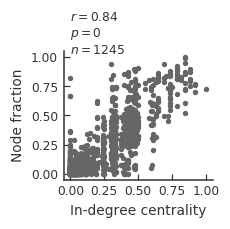

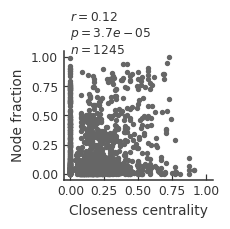

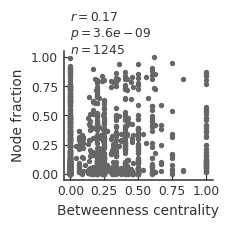

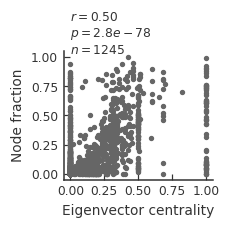

In [56]:
%%time
use_mean = 1
if use_mean == 1:
    temp = data_[:]
else:
    temp = data_f[:]
    temp["az_gd"] = temp.apply(az.genotype_distribution, axis=1)

# Fit only WC interactions
keys = ['AU', 'CG']
   
n = 1
N = 20
name_summing = ["In-degree centrality", "Closeness centrality", "Betweenness centrality", "Eigenvector centrality"]
for j, summing in enumerate(["order", "closeness", "betweenness", "eigenvector"]):
    print("\n" + "-"*20 + "\n")
    print(name_summing[j] + "\n")
    fit, fit_val = [], []
    for _ in xrange(N):
        val = list(np.random.rand(2))       
        res = least_squares(lambda val: fun(val, keys, temp, n, summing), val, loss='cauchy', bounds=([0]*len(val), [np.inf]*len(val)), verbose=0)
        fit.append(az.norm_array(res.x))
        fit_val.append(sse(fit[-1], keys, temp, n, summing))
        print(_, val, "%.3f, %.3f"%(sse(val, keys, temp, n, summing), fit_val[-1]))
    
    fit_val = np.array(fit_val)
    min_fit = np.argmin(fit_val)
    fit = fit[min_fit]
    
    plot_fitted = 0
    if plot_fitted:
        f = plt.figure(figsize=(0.5*len(val), 2/golden))
        ax = plt.gca()
        lab = []
        for i, r in enumerate(fit):
            ax.bar(i, fit[i], color=azp.colors[4])
            lab.append(keys[i])
        ax.set_xticks(range(len(val)))
        ax.set_xticklabels(lab, rotation=90)
        ax.set_ylabel("Edge strength")
        ax.set_xlabel("Interaction")

    f = plot_fractions(fit, keys, temp, n, summing, name_summing[j])
    f.savefig(os.getcwd() + "/extended_data_figures/edf_5c%s.svg"j%, fmt='svg')

### 2

In [9]:
temp = data_[:]
val = [1., 1.]
keys = ['AU', 'CG']
res = least_squares(lambda val: fun(val, keys, temp, 1, "order"), val, loss='cauchy', bounds=([0]*len(val), [np.inf]*len(val)), verbose=0)
rates = {}
for i in range(len(keys)):
    rates[keys[i]] = res.x[i]
    rates[base_comp[keys[i][0]] + base_comp[keys[i][1]]] = res.x[i]
rates = list(az.norm_array([rates[g] if g in rates.keys() else 0. for g in G]))

#Binarized Bryce's ka rates (/min)
ka_rates = {'CG':0.00398, 'GC':0.00398, 'AU':0.00147, 'UA':0.00147} 
ka_rates = [ka_rates[g] if g in ka_rates.keys() else 0. for g in G]

#Binarized Bryce's kb rates (µM/min)
kb_rates = {'CG':0.00051, 'GC':0.00051, 'AU':0.000095, 'UA':0.000095} 
kb_rates = [kb_rates[g] if g in kb_rates.keys() else 0. for g in G]

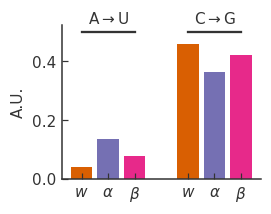

In [10]:
fig_order=15
f = plt.figure(figsize=(7/3., 3/golden))
ax = plt.gca()

for i, k in enumerate([rates, az.norm_array(ka_rates), az.norm_array(kb_rates)]):
    for j, g in enumerate(["AU", "CG"]):
        ax.bar(j*4+i, k[G.index(g)], color=azp.colors[i+1])

ax.set_xticks([0, 1, 2, 4, 5, 6])
ax.set_xticklabels([r"$w$", r"$\alpha$", r"$\beta$", r"$w$", r"$\alpha$", r"$\beta$"])
ax.set_ylabel("A.U.")
ax.plot([0, 2], [0.5, 0.5], color="0.2")
ax.text(1, 0.53, r"A$\rightarrow$U", ha="center")
ax.plot([4, 6], [0.5, 0.5], color="0.2")
ax.text(5, 0.53, r"C$\rightarrow$G", ha="center")

f.savefig(os.getcwd() + "/extended_data_figures/edf_5f.svg", fmt='svg')

### 3

This needs to be removed or better archived (because who knows we might need it at some point)

In [458]:
def dxdt(t, X, nt):
    n = nt.count("1")
    A = azm.network_matrix(nt, ka_rates)
    B = np.matmul(azm.network_matrix(nt, np.array(kb_rates)), 0.1*np.ones(n).reshape((n,)))
    return np.matmul(A, X.reshape(n,)) + B

def resid(T):
    return (az.norm_array(np.vstack(temp.az_list.apply(lambda x: odeint(lambda y, t: dxdt(t, y, x), np.zeros(x.count("1")), np.linspace(0, T, 100))[-1]).values)).flatten() - Y)

def compare_terms(X, nt):
    n = nt.count("1")
    A = azm.network_matrix(nt, ka_rates)
    B = np.matmul(azm.network_matrix(nt, np.array(kb_rates)), 0.1*np.ones(n).reshape((n,)))
    return sum(np.matmul(A, X.reshape(n,)))/sum(B)

t=1h, proportion of networks with at least equal terms = 0.00
t=1h, proportion of networks with at least 2x between terms = 0.00
t=5h, proportion of networks with at least equal terms = 0.92
t=5h, proportion of networks with at least 2x between terms = 0.70


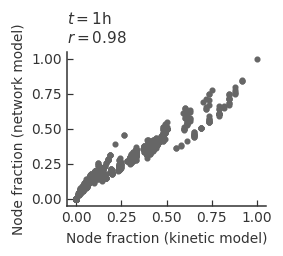

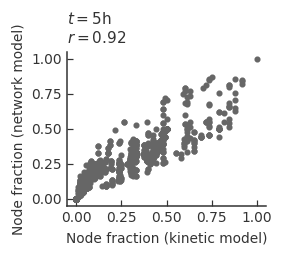

In [472]:
temp = data_[data_.nb_az == 5]
for T in [60, 300]:
    f = plt.figure(figsize=(7./3, 3/golden))
    ax = plt.gca()
    x = np.hstack(temp.az_list.apply(lambda x: [azm.degree(g, x, 1, 'in', rates) for g in azm.transform(x)]).values).flatten()
    r = np.vstack(temp.apply(lambda x: compare_terms(odeint(lambda y, t: dxdt(t, y, x.az_list), np.zeros(x.az_list.count("1")), np.linspace(0, T, 1000))[-1], x.az_list), axis=1))
    print("t=%sh, proportion of networks with at least equal terms = %.2f"%(T/60, (r.flatten() >= 0.5).sum()/float(len(r))))
    print("t=%sh, proportion of networks with at least 2x between terms = %.2f"%(T/60, (r.flatten() >= 1.).sum()/float(len(r))))
    y = az.norm_array(np.vstack(temp.apply(lambda x: list(odeint(lambda y, t: dxdt(t, y, x.az_list), np.zeros(x.az_list.count("1")), np.linspace(0, T, 1000))[-1]), axis=1).values)).flatten()
    ax.plot(x, y, '.', color=azp.colors[7])
    ax.set_xlabel("Node fraction (kinetic model)", fontsize=9)
    ax.set_ylabel("Node fraction (network model)", fontsize=9)
    ax.set_xticks([0., 0.25, 0.5, 0.75, 1.])
    ax.set_yticks([0., 0.25, 0.5, 0.75, 1.])
    plt.tick_params(axis='both', which='major', labelsize=9)
    ax.set_title(r"$t=$%sh"%(T/60) +"\n"r"$r=%.2f$"%(linregress(x, y).rvalue), loc="left", fontsize=10)
    f.savefig(os.getcwd() + "/extended_data_figures/extended_data_figure_%se%s.svg"%(fig_order, T/60), fmt='svg')

# Network identification

In [13]:
hp_prob = [0.018226, 0.068044, 0.392467, 0.424059, 0.088700, 0.008505]
hp_prob += [0.]*(data_f.nb_hp.max()+1-len(hp_prob))

### Network example

In [16]:
nt = azm.transform(["CU", "UG", "AC"])
name = "edf_4a"
azp.az_graphviz(nt, name=name, fmt='svg')
os.remove(os.getcwd() + "\\extended_data_figures\\%s.svg"%name)
os.remove("%s.gv"%name)
os.rename(os.getcwd()+"\\%s.gv.svg"%name, os.getcwd() + "\\extended_data_figures\\%s.svg"%name)

### Expected and measured library fusion distribution

(13, 3.2035570346884645e-09)


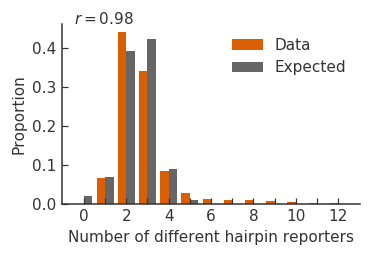

In [43]:
temp = data_f[:]
X = az.norm_array(hp_prob)
Y = Counter(temp.nb_hp.values)
Y = az.norm_array([Y[i] for i in range(len(hp_prob))])

f = plt.figure(figsize=(3.5, 3.5/golden))
ax = plt.gca()
ax.bar(2*np.arange(len(X)), Y, color=azp.colors[1], label="Data")
ax.bar(2*np.arange(len(X))+0.8, X, color=azp.colors[7], label="Expected")
ax.set_xticks(2*np.arange(len(X))+0.4)
ax.set_xticklabels([i if i%2==0 else "" for i in range(len(X))])
ax.set_ylabel("Proportion")
ax.set_xlabel("Number of different hairpin reporters")
lr = linregress(X, Y)
ax.text(-0.5, ax.get_ylim()[1], r"$r=%.2f$"%lr.rvalue)
ax.legend(loc='upper right')
f.savefig(os.getcwd() + "/extended_data_figures/edf_4b.svg"%fig_order, fmt='svg')
print(len(X), lr.pvalue)

### Expected and measured distribution of network sized

(17, 0.00012379488877657769)


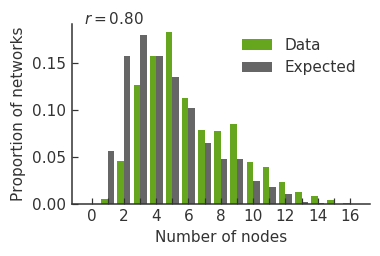

In [44]:
temp = data_f[:]
az_prob = map(lambda x: x.count("1"), az.many_fusions(E, weights=None, nb_fusion=len(temp), params=hp_prob))
c = Counter(az_prob)
X = az.norm_array([float(c[i]) if i in c.keys() else 0. for i in range(17)])
Y = Counter(temp.nb_az.values)
Y = az.norm_array([Y[i] for i in range(17)])

f = plt.figure(figsize=(3.5, 3.5/golden))
ax = plt.gca()
ax.bar(2*np.arange(len(X)), Y, color=azp.colors[4], label="Data")
ax.bar(2*np.arange(len(X))+0.8, X, color=azp.colors[7], label="Expected")
ax.set_xticks(2*np.arange(len(X))+0.4)
ax.set_xticklabels([i if i%2==0 else "" for i in range(len(X))])
ax.set_ylabel("Proportion of networks")
ax.set_xlabel("Number of nodes")
ax.legend(loc='upper right')
lr = linregress(X, Y)
ax.text(-0.5, ax.get_ylim()[1], r"$r=%.2f$"%lr.rvalue)
print(len(X), lr.pvalue)
f.savefig(os.getcwd() + "/extended_data_figures/edf_4c.svg", fmt='svg')

### Correctly coded ribozyme UMI-normalized reads

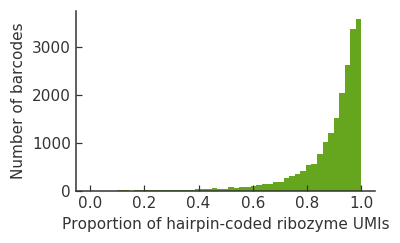

In [22]:
temp = data_f[:]
Y = temp.az_correct.values
f = plt.figure(figsize=(3.5, 3.5/golden))
ax = plt.gca()
ax.hist(Y, np.linspace(0, 1, 50), color=azp.colors[4])
ax.set_xlabel("Proportion of hairpin-coded ribozyme UMIs")
ax.set_ylabel("Number of barcodes")
f.savefig(os.getcwd() + "/extended_data_figures/edf_4d.svg", fmt='svg')

### Network expected versus measured number of replicates

In [45]:
list_exp = {"jan17":"A", "apr17":"E"}
X, Y = [], []
for exp in ["jan17", "apr17"]:
    temp = data_f[data_f.spBC_letter == list_exp[exp]]
    N = 50000
    temp = temp.groupby(["az_list"]).size().reset_index(name="nb_replicates")
    weights = pd.read_csv("D:/EvoEvo/miseq17/apr17/starting_emulsions_dist.csv")
    weights = weights.pivot(index="experiment", columns="hp", values="proportion")
    weights = list(weights[HP].ix[exp].values)
    temp_th = Counter(az.many_fusions(E, weights=weights, nb_fusion=N))
    def get_nb_replicates_th(x, temp_th):
        if x not in temp_th.keys():
            return 0.0
        else:
            return temp_th[x]/float(N)
    temp["nb_replicates_th"] = temp["az_list"].apply(lambda x: get_nb_replicates_th(x, temp_th))
    temp["nb_replicates"] = temp["nb_replicates"]/float(sum(temp["nb_replicates"].values))
    X.append(temp.nb_replicates_th.values)
    Y.append(temp.nb_replicates.values)
X = np.hstack(X)
Y = np.hstack(Y)

(2160, 0.0)


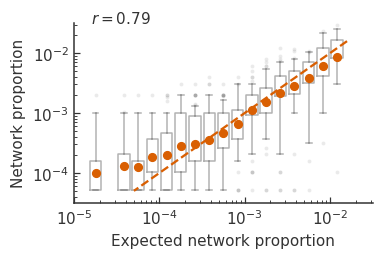

In [47]:
f = plt.figure()
ax = plt.gca()
M = X > 0
X_, Y_ = np.log10(X[M]), np.log10(Y[M])
azp.styled_boxplot(ax, X_, Y_, nbins=np.linspace(-5, 0, 31), nb_points=10, whis=[5, 95])
ax.plot([-1.8, -4.3], [-1.8, -4.3], '--', color=azp.colors[1])
mjt, mjtlab, mnt = azp.custom_log_ticks(-5, -1, base_10=True)
ax.set_xticks(mjt, minor=False)
ax.set_xticks(mnt, minor=True)
ax.set_xticklabels(mjtlab)
ax.set_yticks(mjt, minor=False)
ax.set_yticks(mnt, minor=True)
ax.set_yticklabels(mjtlab)
ax.set_xlim(-5, -1.5)
ax.set_ylim(-4.5, -1.5)
lr = linregress(X, Y)
ax.text(-4.8, ax.get_ylim()[1], r"$r=%.2f$"%lr.rvalue)
ax.set_xlabel("Expected network proportion")
ax.set_ylabel("Network proportion")
f.savefig(os.getcwd() + "/supplementary_figures/edf_4e.svg"%fig_order, fmt='svg')
print(len(X), lr.pvalue)

# Errorbar distribution

### Node fraction s.d.

C:\Users\Simon\Anaconda2\lib\site-packages\ipykernel\__main__.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  app.launch_new_instance()


'\nf = plt.figure()\nax = plt.gca()\n#azp.styled_boxplot(ax, np.hstack(X), np.hstack(Z), np.linspace(0, 1, 20))\nax.plot(np.hstack(X), np.hstack(Z), \'.\', color=azp.colors[1])\nax.set_xlabel("Node fraction")\nax.set_ylabel("Node fraction c.v.")\n#f.savefig(os.getcwd() + "/supplementary_figures/S%sB.svg"%fig_order, fmt=\'svg\')\n'

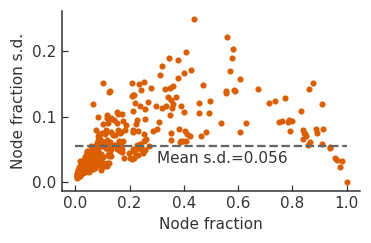

In [30]:
#This needs to be archived

temp = data_f.groupby("az_list").size().reset_index(name="nb_replicate").sort_values(by="nb_replicate", ascending=False)
temp = data_f[data_f.az_list.isin(temp[temp.nb_replicate >= 50].az_list.values)]
temp["az_gd"] = temp.apply(az.genotype_distribution, axis=1)
Y = []
X = []
Z = []
for name, x in temp.groupby("az_list"):
    y = np.vstack(x.az_gd.values)
    X.append(y.mean(0))
    Y.append(y.std(0))
    Z.append(y.std(0)/y.mean(0))
    
f = plt.figure()
ax = plt.gca()
ax.plot(np.hstack(X), np.hstack(Y), '.', color=azp.colors[1])
ax.plot([0, 1], [np.hstack(Y).mean()]*2, "--", color=azp.colors[7])
ax.text(0.3, np.hstack(Y).mean()*0.85, "Mean s.d.=%.3f"%(np.hstack(Y).mean()), va='top')
t = np.linspace(0, 1)
ax.set_xlabel("Node fraction")
ax.set_ylabel("Node fraction s.d.")
f.savefig(os.getcwd() + "/extended_data_figures/%sb.svg"%fig_order, fmt='svg')

"""
f = plt.figure()
ax = plt.gca()
#azp.styled_boxplot(ax, np.hstack(X), np.hstack(Z), np.linspace(0, 1, 20))
ax.plot(np.hstack(X), np.hstack(Z), '.', color=azp.colors[1])
ax.set_xlabel("Node fraction")
ax.set_ylabel("Node fraction c.v.")
#f.savefig(os.getcwd() + "/supplementary_figures/S%sB.svg"%fig_order, fmt='svg')
"""

C:\Users\Simon\Anaconda2\lib\site-packages\ipykernel\__main__.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  app.launch_new_instance()
C:\Users\Simon\Anaconda2\lib\site-packages\ipykernel\__main__.py:11: RuntimeWarning: invalid value encountered in divide


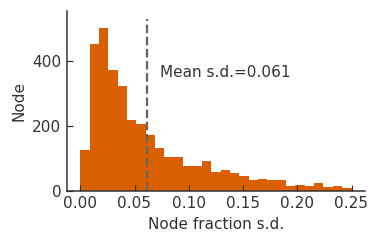

In [20]:
temp = data_f.groupby("az_list").size().reset_index(name="nb_replicate").sort_values(by="nb_replicate", ascending=False)
temp = data_f[data_f.az_list.isin(temp[temp.nb_replicate >= 5].az_list.values)]
temp["az_gd"] = temp.apply(az.genotype_distribution, axis=1)
Y = []
X = []
Z = []
for name, x in temp.groupby("az_list"):
    y = np.vstack(x.az_gd.values)
    X.append(y.mean(0))
    Y.append(y.std(0))
    Z.append(y.std(0)/y.mean(0))
    
f = plt.figure()
ax = plt.gca()
ax.hist(np.hstack(Y), np.linspace(0, 0.25, 30), color=azp.colors[1])
ax.plot([np.hstack(Y).mean()]*2, [0, ax.get_ylim()[-1]], "--", color=azp.colors[7])
ax.text(np.hstack(Y).mean()*1.2, ax.get_ylim()[-1]*0.7, "Mean s.d.=%.3f"%(np.hstack(Y).mean()), va='top')
ax.set_xlabel("Node fraction s.d.")
ax.set_ylabel("Node")
f.savefig(os.getcwd() + "/extended_data_figures/edf_5b.svg"%fig_order, fmt='svg')

### Number of replicates

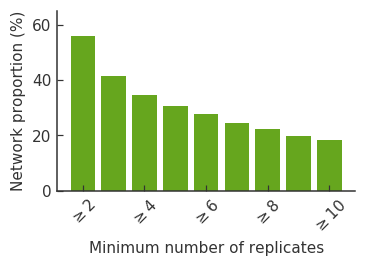

In [26]:
temp = data_f.groupby("az_list").size().reset_index(name="nb_replicates")
X = range(2, 11)
Y = [len(temp[temp.nb_replicates >= x])/float(len(temp))*100 for x in X]
f = plt.figure(figsize=(3.5, 3.5/golden))
ax = plt.gca()
ax.bar(X, Y, color=azp.colors[4])
ax.set_ylabel("Network proportion (%)")
ax.set_xlabel("Minimum number of replicates")
ax.set_xticks(X[::2])
ax.set_xticklabels([r"$\geq %s$"%x for x in X[::2]], rotation=45)
ax.set_ylim(0, 65)
f.savefig(os.getcwd() + "/extended_data_figures/edf_5a.svg"%fig_order, fmt='svg')

### Example data of a network

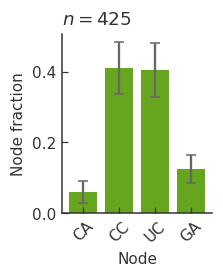

In [442]:
temp = data_f.groupby("az_list").size().reset_index(name="nb_replicates").sort_values(by="nb_replicates", ascending=False)[:3]
width = az.norm_array(temp.az_list.apply(lambda x: x.count("1")).values)
j = 0
for name, x in temp[-1:].iterrows():
    f = plt.figure(figsize=(width[-1:][j]*7.5, 3.5/golden))
    ax = plt.gca()
    n = x.az_list.count("1")
    Y = np.vstack(data_f[data_f.az_list == x.az_list].az_gd.values)
    #ax.plot(np.vstack([range(n)]*len(Y)).flatten(), Y.flatten(), '.')
    ax.bar(range(n), Y.mean(0), yerr=Y.std(0), color=azp.colors[4], capsize=3, ecolor=azp.colors[7])
    ax.set_ylabel("Node fraction")
    ax.set_xlabel("Node")
    ax.set_xticks(range(n))
    ax.set_xticklabels(azm.transform(x.az_list), rotation=45)
    ax.set_title(r"$n=%s$"%len(Y), loc='left')
    ax.set_ylim(0, ax.get_ylim()[1])
    name = "%sd_right"%(fig_order)
    azp.az_graphviz(x.az_list, name=name, fmt='svg')
    os.remove(os.getcwd() + "\\extended_data_figures\\%s.svg"%name)
    os.remove("%s.gv"%name)
    os.rename(os.getcwd()+"\\%s.gv.svg"%name, os.getcwd() + "\\extended_data_figures\\%s.svg"%name)
    f.savefig(os.getcwd() + "/extended_data_figures/edf_5c_left.svg"%(fig_order, j+1), fmt='svg')
    j += 1

### Nodes fractions accross the two technical replicates

(2047, 0.0)


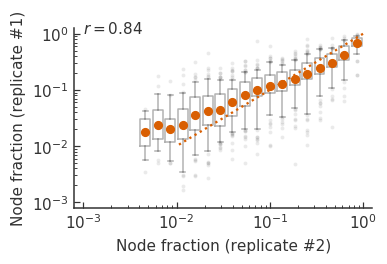

In [48]:
X = az.filter_and_mean(data_f[data_f.spBC_letter == "E"], filters={"E":[0, 0]})[0]
Y = az.filter_and_mean(data_f[data_f.spBC_letter == "A"], filters={"A":[0, 0]})[0]
common = set(X.az_list.values).intersection(set(Y.az_list.values))
X_ = X[X.az_list.isin(common)].set_index("az_list")
X_["xdata"] = X_["az_gd"].values
Y_ = Y[Y.az_list.isin(common)].set_index("az_list")
Y_["ydata"] = Y_["az_gd"].values
temp = pd.concat([X_["xdata"], Y_["ydata"]], axis=1)
x = np.hstack(temp.xdata.values)
y = np.hstack(temp.ydata.values)
M = (x > 0) * (y > 0)
x, y = np.log10(x[M]), np.log10(y[M])
f = plt.figure(figsize=(3.5, 3.5/golden))
ax = plt.gca()
azp.styled_boxplot(ax, x, y, np.linspace(-4, 0, 31), whis=[5, 95], nb_points=10);
ax.plot([0, -2.], [0, -2.], ":", color=azp.colors[1])
mjt, mjtlab, mnt = azp.custom_log_ticks(-3, 0, base_10=True)
ax.set_xticks(mjt, minor=False)
ax.set_xticks(mnt, minor=True)
ax.set_xticklabels(mjtlab)
ax.set_xlim(-3.1, 0.1)
ax.set_ylim(-3.1, 0.1)
ax.set_yticks(mjt, minor=False)
ax.set_yticks(mnt, minor=True)
ax.set_yticklabels(mjtlab)
ax.set_ylabel("Node fraction (replicate #1)")
ax.set_xlabel("Node fraction (replicate #2)")
ax.text(-3, 0, r"$r=%.2f$"%linregress(np.hstack(temp.xdata.values), np.hstack(temp.ydata.values)).rvalue)
print(len(np.hstack(temp.xdata.values)), linregress(np.hstack(temp.xdata.values), np.hstack(temp.ydata.values)).pvalue)
f.savefig(os.getcwd() + "/extended_data_figures/edf_5c.svg", fmt='svg')

In [13]:
#Loading the data
X = az.filter_and_mean(data_f[data_f.spBC_letter == "E"], filters={"E":[0, 0]})[0]
Y = az.filter_and_mean(data_f[data_f.spBC_letter == "A"], filters={"A":[0, 0]})[0]
common = set(X.az_list.values).intersection(set(Y.az_list.values))
X_ = X[X.az_list.isin(common)].set_index("az_list")
X_["xdata"] = X_["az_gd"].values
Y_ = Y[Y.az_list.isin(common)].set_index("az_list")
Y_["ydata"] = Y_["az_gd"].values
temp = pd.concat([X_["xdata"], Y_["ydata"]], axis=1)
x = np.hstack(temp.xdata.values)
y = np.hstack(temp.ydata.values)

LinregressResult(slope=0.7224370208652567, intercept=0.04379718723034787, rvalue=0.8381104294476223, pvalue=0.0, stderr=0.010397940476088613)
(2047, 0.0)


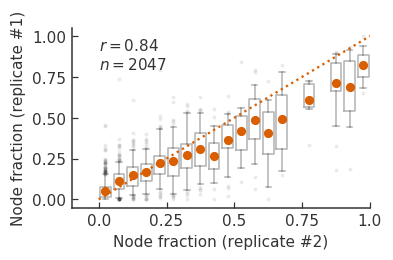

In [51]:
#Plotting

f = plt.figure(figsize=(3.5, 3.5/golden))
ax = plt.gca()
azp.styled_boxplot(ax, x, y, np.linspace(0, 1, 21), whis=[5, 95], nb_points=10, ticks=True);
ax.plot([0, 1], [0, 1], ":", color=azp.colors[1])
ax.set_ylabel("Node fraction (replicate #1)")
ax.set_xlabel("Node fraction (replicate #2)")
lr = linregress(np.hstack(temp.xdata.values), np.hstack(temp.ydata.values))
print(lr)
ax.text(0, 0.8, r"$r=%.2f$"%lr.rvalue  + "\n" + r"$n=%s$"%len(x))
ax.set_xlim(-0.1, 1)
ax.set_xticks([0, 0.25, 0.5, 0.75, 1])
ax.set_xticklabels([0.00, 0.25, 0.5, 0.75, 1.00])
print(len(np.hstack(temp.xdata.values)), linregress(np.hstack(temp.xdata.values), np.hstack(temp.ydata.values)).pvalue)
f.savefig(os.getcwd() + "/extended_data_figures/edf_5c.svg", fmt='svg')

### Control for quantification bias and cross-talk

In [52]:
data_ct = pd.read_csv("meta_UMI_filtered_jul18.csv")
temp = data_ct[:]
temp = temp.groupby(["dpBC", "new_G"]).size().reset_index(name="nb_UMI").pivot(index="dpBC", columns="new_G", values="nb_UMI")
temp = temp.fillna(0).reset_index()
temp["az_total"] = temp.get([s for s in "ACGU"]).values.sum(1)
temp["az_max"] = temp.get([s for s in "ACGU"]).values.max(1)
for j, l in enumerate(list("ABCD")):
    temp["hp_%s"%l] = temp["hp_%s"%(2*j)] + temp["hp_%s"%(2*j+1)]
temp["hp_total"] = temp.get(["hp_%s"%s for s in "ABCD"]).values.sum(1)
temp["hp_max"] = temp.get(["hp_%s"%s for s in "ABCD"]).values.max(1)
temp = temp[(temp.az_total >= 20) & (temp.hp_total >= 10)]

In [53]:
em_prop = [['A', 'B', 'C', 'D', 'AB', 'AC', 'AD', 'BC', 'BD', 'CD', 'ABC', 'ABD', 'BCD', 'ABCD', ''], [0.25, 0.25, 0.25, 0.25, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]]

def return_prop_emulsion(th):
    Y = temp.get(["hp_%s"%l for l in range(8)]).values
    A = np.vstack([list("ABCD")]*len(Y))
    M = az.norm_array(Y) > th
    M = np.array(map(lambda x: [x[2*i] and x[2*i+1] for i in range(4)], M))
    y = ["".join(A[i][M[i]]) for i in range(len(A))]
    C = Counter(y)
    y = az.norm_array([C[e] for e in em_prop[0]])
    return y

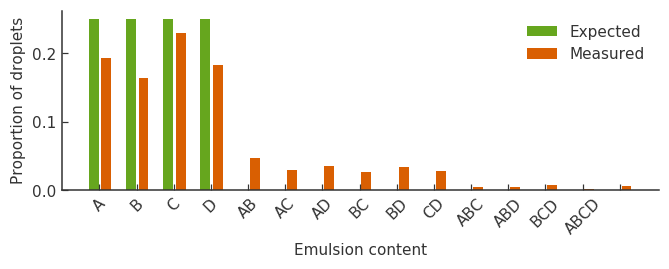

In [54]:
y = return_prop_emulsion(0.075)
f = plt.figure(figsize=(7, 3.5/golden))
ax = plt.gca()
ax.bar(3*np.arange(len(y)), em_prop[1], color=azp.colors[4], label="Expected")
ax.bar(3*np.arange(len(y))+1, y, color=azp.colors[1], label="Measured")
ax.set_xticks(3*np.arange(len(y))+0.45)
ax.set_xticklabels(em_prop[0], rotation=45)
ax.legend(loc="upper right")
ax.set_ylabel("Proportion of droplets")
ax.set_xlabel("Emulsion content")
f.savefig(os.getcwd() + "/extended_data_figures/edf_5e.svg", fmt='svg')

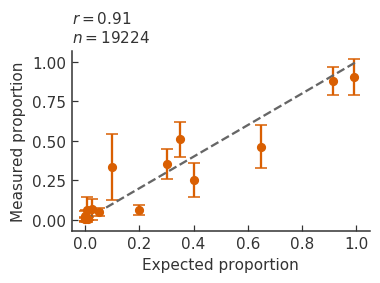

In [13]:
def which_group_percentage(x, th):
    y = az.norm_array(x.get(["hp_%s"%l for l in range(8)]).values)
    m = y > th
    m = np.array([m[2*i] and m[2*i+1] for i in range(4)])
    return ("".join(np.array(list("ABCD"))[m]))

temp["hp_group"] = temp.apply(lambda x: which_group_percentage(x, 0.075), axis=1)

exp_values = {"A": [0.3, 0.2, 0.4, 0.1], "B": [0.025, 0.01, 0.05, 0.915], "C":[0.005, 0.001, 0.0025, 0.9915], "D":[0.65, 0.0005, 0.0001, 0.3494]}
Y = az.norm_array(temp[temp.hp_group.apply(lambda x: len(x) == 1)].get(list("ACUG")).values).flatten()
Yth = np.vstack(temp[temp.hp_group.apply(lambda x: len(x) == 1)].hp_group.apply(lambda x: exp_values[x])).flatten()
Xth = sorted(np.hstack(exp_values.values()))
X = []
for x in Xth:
    X.append([Y[i] for i in range(len(Y)) if np.isclose(Yth[i], x)])
f = plt.figure()
ax = plt.gca()
ax.errorbar(Xth, map(np.mean, X), yerr=map(np.std, X), fmt=".", color=azp.colors[1], capsize=4, ms=10)
ax.plot([0, 1], [0, 1], "--" , color=azp.colors[7])
lr = linregress(Yth.flatten(), Y.flatten())
ax.set_xlabel("Expected proportion")
ax.set_ylabel("Measured proportion")
ax.set_title(r"$r=%.2f$"%lr.rvalue+"\n"+r"$n=%s$"%len(Y), loc='left', fontsize=10)
f.savefig(os.getcwd() + "/extended_data_figures/edf_5f.svg", fmt='svg')

LinregressResult(slope=0.5241747242247894, intercept=-0.31697776379755405, rvalue=0.7921022266168005, pvalue=0.0, stderr=0.0031512464415363287)
Wall time: 5.04 s


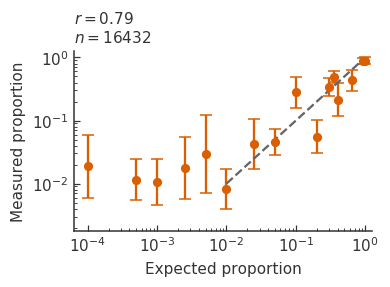

In [14]:
%%time
exp_values = {"A": [0.3, 0.2, 0.4, 0.1], "B": [0.025, 0.01, 0.05, 0.915], "C":[0.005, 0.001, 0.0025, 0.9915], "D":[0.65, 0.0005, 0.0001, 0.3494]}
Y = az.norm_array(temp[temp.hp_group.apply(lambda x: len(x) == 1)].get(list("ACUG")).values).flatten()
Yth = np.vstack(temp[temp.hp_group.apply(lambda x: len(x) == 1)].hp_group.apply(lambda x: exp_values[x])).flatten()
M = np.isclose(Y, 0)
Y, Yth = np.log10(Y[~M]), np.log10(Yth[~M])
Xth = sorted(np.log10(np.hstack(exp_values.values())))
X = []
for x in Xth:
    X.append([Y[i] for i in range(len(Y)) if np.isclose(Yth[i], x)])
f = plt.figure()
ax = plt.gca()
ax.errorbar(Xth, map(np.mean, X), yerr=map(np.std, X), fmt=".", color=azp.colors[1], capsize=4, ms=10)
ax.plot([-2, 0], [-2, 0], "--" , color=azp.colors[7])
print(linregress(Yth.flatten(), Y.flatten()))
mjt, mjtlab, mnt = azp.custom_log_ticks(-4, 0, base_10=True)
ax.set_xticks(mjt, minor=False)
ax.set_xticks(mnt, minor=True)
ax.set_xticklabels(mjtlab)
ax.set_xlim(-4.2, 0.1)
ax.set_yticks(mjt, minor=False)
ax.set_yticks(mnt, minor=True)
ax.set_yticklabels(mjtlab)
ax.set_ylim(-2.75, 0.1)
ax.set_xlabel("Expected proportion")
ax.set_ylabel("Measured proportion")
lr = linregress(Yth.flatten(), Y.flatten())
ax.set_title(r"$r=%.2f$"%lr.rvalue+"\n"+r"$n=%s$"%len(Y), loc='left', fontsize=10)
f.savefig(os.getcwd() + "/extended_data_figures/edf_5g.svg", fmt='svg')

# Figure 2.B for all sizes

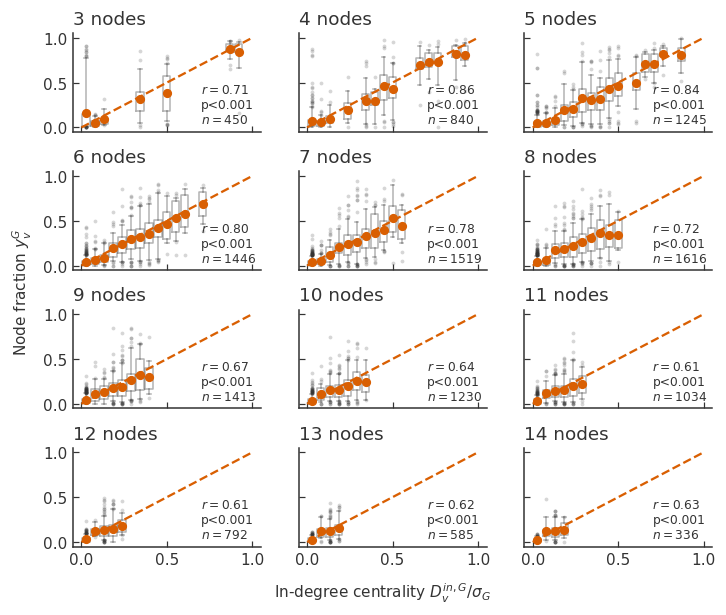

In [13]:
fig_order = 4

f, axa = plt.subplots(4, 3, sharex=True, sharey=True, figsize=(7.5, 2.5/golden*4))
for size in range(3, 15):
    ax = axa[(size-3)/3, (size-3)%3]
    temp = data_[data_.nb_az == size]
    X = np.hstack(temp.az_list.apply(lambda x: [azm.degree(g, x, 1, 'in', rates) for g in azm.transform(x)]).values)
    Y = np.hstack(temp.az_gd.values)
    bxp = azp.styled_boxplot(ax, X, Y, nbins=np.linspace(0, 1, 20), nb_points=10, showfliers=True, alphafliers=0.2, alpha=0.3, whis=[5, 95]);
    ax.plot([0, 1], [0, 1], "--", color=azp.colors[1])
    h = 0.05
    ymin, ymax = 0, 1
    xmin, xmax = 0, 1
    ax.set_xlim(xmin-h, xmax+h)
    ax.set_ylim(ymin-h, ymax+h)
    m = mpl.ticker.MaxNLocator(nbins=2)
    ax.set_xticks(m.tick_values(xmin, xmax))
    ax.set_xticklabels(m.tick_values(xmin, xmax))
    ax.set_yticks(m.tick_values(ymin, ymax))
    ax.set_yticklabels(m.tick_values(ymin, ymax))
    lr = stats.linregress(X, Y)
    #ax.text(0.7, 0.15, r"$r^2=%.2f$"%(lr.rvalue**2), va='center')
    if lr.pvalue < 0.001:
        pvalue = "p<0.001"
    else:
        pvalue = r"$p=%.2g$"%lr.pvalue
    ax.text(0.7, 0.25, r"$r=%.2f$"%lr.rvalue + "\n" + pvalue + "\n" + r"$n=%s$"%len(X), va='center', fontsize=8)
    ax.set_title("%s nodes"%size, loc='left')
f.text(0.5, 0.05, "In-degree centrality " + r"$D^{in,G}_{v}/\sigma_G$", ha='center')
f.text(0.05, 0.5, "Node fraction " + r"$y^G_v$", rotation=90, va='center')
f.subplots_adjust(hspace=0.4)
f.savefig(os.getcwd() + "/extended_data_figures/edf_7.svg", fmt='svg')

# Distribution of number of UMI per droplets

In [670]:
fig_order = 2

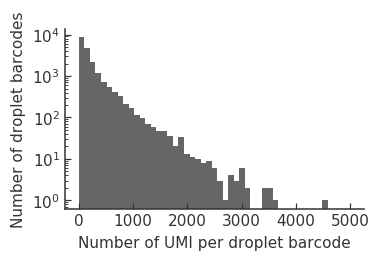

In [425]:
f = plt.figure(figsize=(3.5, 3.5/golden))
ax = plt.gca()
ax.hist(data_f.az_total, np.linspace(0, 5000, 50), log=1, color=azp.colors[7])
ax.set_xlabel("Number of UMI per droplet barcode")
ax.set_ylabel("Number of droplet barcodes")
f.savefig(os.getcwd() + "/extended_data_figures/edf_3f.svg"%fig_order, fmt='svg')

# Thresholds

In [650]:
%%time
meta = pd.read_csv("azoarcus_networks_final_data.csv")
meta["spBC_letter"] = meta["dpBC_"].apply(lambda x: x.split("_")[-1])
meta["dpBC_"] = meta["dpBC_"].apply(lambda x: x.replace("G", "E"))

Wall time: 10.4 s


In [695]:
import time
import datetime
def custom_hr_time():
    timestamp = time.time()
    value = datetime.datetime.fromtimestamp(timestamp)
    return value.strftime('%Y-%m-%d %H:%M:%S')

### 1

In [697]:
#Careful this will take a few hours to run
%%time
with open(os.getcwd() + "/extended_data_figures/%sf.csv"%fig_order, "w") as f:
    for t in np.linspace(0, 25, 51):
        print("Starting %s"%t)
        print(custom_hr_time())
        temp = az.compute_data(meta, dpBC="dpBC_", t=t/100.)
        temp = Counter(temp[(temp.hp_total >= 10) & (temp.az_total >= 20)].nb_hp.values)
        temp = list(az.norm_array([temp[i] if i in temp.keys() else 0. for i in range(25)]))
        f.write(",".join(map(str, [t] + temp)) + "\n")
        print("Done %s"%t)
        print(custom_hr_time())

Starting 0.0
2018-04-10 18:44:25
Done 0.0
2018-04-10 19:00:00
Starting 0.5
2018-04-10 19:00:00
Done 0.5
2018-04-10 19:15:32
Starting 1.0
2018-04-10 19:15:32
Done 1.0
2018-04-10 19:31:14
Starting 1.5
2018-04-10 19:31:14
Done 1.5
2018-04-10 19:47:07
Starting 2.0
2018-04-10 19:47:07
Done 2.0
2018-04-10 20:02:25
Starting 2.5
2018-04-10 20:02:25
Done 2.5
2018-04-10 20:17:14
Starting 3.0
2018-04-10 20:17:14
Done 3.0
2018-04-10 20:32:01
Starting 3.5
2018-04-10 20:32:01
Done 3.5
2018-04-10 20:46:52
Starting 4.0
2018-04-10 20:46:52
Done 4.0
2018-04-10 21:01:41
Starting 4.5
2018-04-10 21:01:41
Done 4.5
2018-04-10 21:16:29
Starting 5.0
2018-04-10 21:16:29
Done 5.0
2018-04-10 21:31:18
Starting 5.5
2018-04-10 21:31:18
Done 5.5
2018-04-10 21:46:04
Starting 6.0
2018-04-10 21:46:04
Done 6.0
2018-04-10 22:00:49
Starting 6.5
2018-04-10 22:00:49
Done 6.5
2018-04-10 22:15:37
Starting 7.0
2018-04-10 22:15:37
Done 7.0
2018-04-10 22:30:25
Starting 7.5
2018-04-10 22:30:25
Done 7.5
2018-04-10 22:45:13
Starting

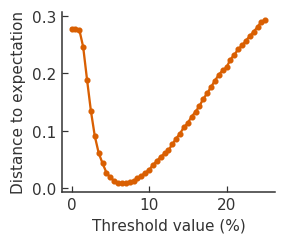

In [737]:
temp = pd.read_csv("extended_data_figures/%sf.csv"%fig_order, names=["threshold"] + ["#%s"%i for i in range(25)])
Yth = az.norm_array(hp_prob + [0.]*(25-len(hp_prob)))
Y = ((temp.get(["#%s"%i for i in range(25)]).values - np.vstack([Yth]*len(temp)))**2).sum(1)
X = np.linspace(0, 25, 51)
f = plt.figure(figsize=(2.5, 3.5/golden))
ax = plt.gca()
ax.plot(X, Y, '.-', color=azp.colors[1])
ax.set_ylabel("Distance to expectation")
ax.set_xlabel("Threshold value (%)")
f.savefig(os.getcwd() + "/extended_data_figures/edf_3g.svg"%fig_order, fmt='svg')

### 2

In [725]:
temp = az.compute_data(meta, dpBC="dpBC_", t=0.075)

In [719]:
%%time
with open(os.getcwd() + "/extended_data_figures/%sg.csv"%fig_order, "w") as f:
    for x in range(20):
        print("Starting %s: %s"%(x, custom_hr_time()))
        temp_ = Counter(temp[(temp.hp_total >= x) & (temp.az_total >= 20)].nb_hp.values)
        temp_ = list(az.norm_array([temp_[i] if i in temp_.keys() else 0. for i in range(25)]))
        f.write(",".join(map(str, [x] + temp_)) + "\n")
        print("Done %s: %s"%(x, custom_hr_time()))

Starting 0: 2018-04-11 11:25:30
Done 0: 2018-04-11 11:25:30
Starting 1: 2018-04-11 11:25:30
Done 1: 2018-04-11 11:25:30
Starting 2: 2018-04-11 11:25:30
Done 2: 2018-04-11 11:25:30
Starting 3: 2018-04-11 11:25:30
Done 3: 2018-04-11 11:25:31
Starting 4: 2018-04-11 11:25:31
Done 4: 2018-04-11 11:25:31
Starting 5: 2018-04-11 11:25:31
Done 5: 2018-04-11 11:25:31
Starting 6: 2018-04-11 11:25:31
Done 6: 2018-04-11 11:25:31
Starting 7: 2018-04-11 11:25:31
Done 7: 2018-04-11 11:25:31
Starting 8: 2018-04-11 11:25:31
Done 8: 2018-04-11 11:25:31
Starting 9: 2018-04-11 11:25:31
Done 9: 2018-04-11 11:25:31
Starting 10: 2018-04-11 11:25:31
Done 10: 2018-04-11 11:25:31
Starting 11: 2018-04-11 11:25:31
Done 11: 2018-04-11 11:25:31
Starting 12: 2018-04-11 11:25:31
Done 12: 2018-04-11 11:25:31
Starting 13: 2018-04-11 11:25:31
Done 13: 2018-04-11 11:25:31
Starting 14: 2018-04-11 11:25:31
Done 14: 2018-04-11 11:25:31
Starting 15: 2018-04-11 11:25:31
Done 15: 2018-04-11 11:25:31
Starting 16: 2018-04-11 11:2

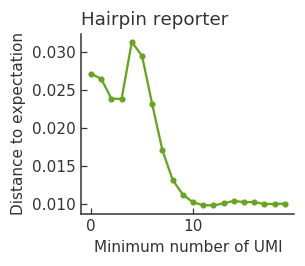

In [740]:
temp_ = pd.read_csv("extended_data_figures/%sg.csv"%fig_order, names=["threshold"] + ["#%s"%i for i in range(25)])
Yth = az.norm_array(hp_prob + [0.]*(25-len(hp_prob)))
Y = ((temp_.get(["#%s"%i for i in range(25)]).values - np.vstack([Yth]*len(temp_)))**2).sum(1)
X = range(20)
f = plt.figure(figsize=(2.5, 3.5/golden))
ax = plt.gca()
ax.plot(X, Y, '.-', color=azp.colors[4])
ax.set_ylabel("Distance to expectation")
ax.set_xlabel("Minimum number of UMI")
ax.set_title("Hairpin reporter", loc='left')
f.savefig(os.getcwd() + "/extended_data_figures/edf_3h.svg"%fig_order, fmt='svg')

### 3

In [728]:
%%time
with open(os.getcwd() + "/extended_data_figures/%sh.csv"%fig_order, "w") as f:
    for x in range(50):
        print("Starting %s: %s"%(x, custom_hr_time()))
        temp_ = Counter(temp[(temp.hp_total >= 10) & (temp.az_total >= x)].nb_hp.values)
        temp_ = list(az.norm_array([temp_[i] if i in temp_.keys() else 0. for i in range(25)]))
        f.write(",".join(map(str, [x] + temp_)) + "\n")
        print("Done %s: %s"%(x, custom_hr_time()))

Starting 0: 2018-04-11 13:06:28
Done 0: 2018-04-11 13:06:28
Starting 1: 2018-04-11 13:06:28
Done 1: 2018-04-11 13:06:28
Starting 2: 2018-04-11 13:06:28
Done 2: 2018-04-11 13:06:28
Starting 3: 2018-04-11 13:06:28
Done 3: 2018-04-11 13:06:28
Starting 4: 2018-04-11 13:06:28
Done 4: 2018-04-11 13:06:28
Starting 5: 2018-04-11 13:06:28
Done 5: 2018-04-11 13:06:28
Starting 6: 2018-04-11 13:06:28
Done 6: 2018-04-11 13:06:28
Starting 7: 2018-04-11 13:06:28
Done 7: 2018-04-11 13:06:28
Starting 8: 2018-04-11 13:06:28
Done 8: 2018-04-11 13:06:28
Starting 9: 2018-04-11 13:06:28
Done 9: 2018-04-11 13:06:28
Starting 10: 2018-04-11 13:06:28
Done 10: 2018-04-11 13:06:28
Starting 11: 2018-04-11 13:06:28
Done 11: 2018-04-11 13:06:28
Starting 12: 2018-04-11 13:06:28
Done 12: 2018-04-11 13:06:28
Starting 13: 2018-04-11 13:06:28
Done 13: 2018-04-11 13:06:28
Starting 14: 2018-04-11 13:06:28
Done 14: 2018-04-11 13:06:28
Starting 15: 2018-04-11 13:06:28
Done 15: 2018-04-11 13:06:28
Starting 16: 2018-04-11 13:0

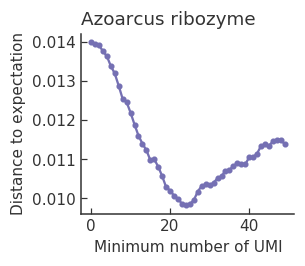

In [741]:
temp_ = pd.read_csv("extended_data_figures/%sh.csv"%fig_order, names=["threshold"] + ["#%s"%i for i in range(25)])
Yth = az.norm_array(hp_prob + [0.]*(25-len(hp_prob)))
Y = ((temp_.get(["#%s"%i for i in range(25)]).values - np.vstack([Yth]*len(temp_)))**2).sum(1)
X = range(50)
f = plt.figure(figsize=(2.5, 3.5/golden))
ax = plt.gca()
ax.plot(X, Y, '.-', color=azp.colors[2])
ax.set_ylabel("Distance to expectation")
ax.set_xlabel("Minimum number of UMI")
ax.set_title("Azoarcus ribozyme", loc='left')
f.savefig(os.getcwd() + "/extended_data_figures/edf_3i.svg"%fig_order, fmt='svg')

# Node perturbation

In [476]:
fig_order = 8

In [33]:
%%time
size = range(4, 17)
if type(size) == list:
    temp = pd.concat([azm.transform_epi(size_, epi, rates) for size_ in size], axis=0)
else:
    temp = azm.transform_epi(size, epi, rates)
temp_plus = temp[(temp.edge_a_v > 0.01) & (temp.sigma_g > 0.01)]
temp_plus["n"] = temp_plus.deg_out_a/temp_plus.edge_a_v
temp_plus["m"] = temp_plus.apply(lambda x: int(x.deg_in_v/x.edge_a_v), axis=1)
temp_plus["x"] = temp_plus.sigma_g/temp_plus.edge_a_v
temp_plus = temp_plus.round(3)
base_comp = {"A":"U", "U":"A", "C":"G", "G":"C"}
temp_minus = temp[(temp.edge_a_v < 0.01) & (temp.sigma_g > 0.01)]
temp_minus["edge_a_v"] = temp_minus.mutation.apply(lambda x: rates[G.index(x[0] + base_comp[x[0]])])
temp_minus["n"] = temp_minus.deg_out_a/temp_minus.edge_a_v
temp_minus["m"] = temp_minus.apply(lambda x: x.deg_in_v/x.edge_a_v, axis=1)
temp_minus["m"] = temp_minus.m.round(2)
temp_minus["x"] = temp_minus.sigma_g/temp_minus.edge_a_v
temp_minus = temp_minus.round(3)

C:\Users\Simon\Anaconda2\lib\site-packages\ipykernel\__main__.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
C:\Users\Simon\Anaconda2\lib\site-packages\ipykernel\__main__.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
C:\Users\Simon\Anaconda2\lib\site-packages\ipykernel\__main__.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-

Wall time: 17.9 s


C:\Users\Simon\Anaconda2\lib\site-packages\ipykernel\__main__.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
C:\Users\Simon\Anaconda2\lib\site-packages\ipykernel\__main__.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
C:\Users\Simon\Anaconda2\lib\site-packages\ipykernel\__main__.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexi

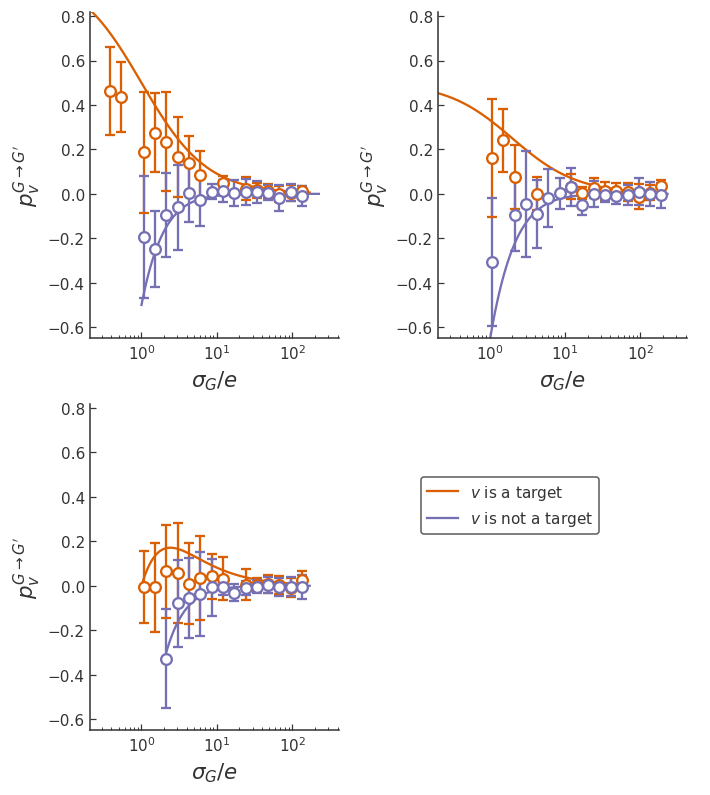

In [39]:
def plot_aux(ax, m, n, plus, color, what="both", fmt="o"):
    nbins = 20
    xbins = np.logspace(-0.5, 2.5, nbins+1)
    if plus:
        temp_ = temp_plus[temp_plus.n.apply(lambda x: np.isclose(x, n)) & temp_plus.m.apply(lambda x: np.isclose(x, m))]
        if m == 0: mmin = 0.05/0.45
        else: mmin = m*n
        x = np.logspace(np.log10(mmin), np.log10(temp_.x.max()), 100)
        y = (1 - n*m/x)/(n+x)
    else:
        temp_ = temp_minus[temp_minus.n.apply(lambda x: np.isclose(x, n)) & temp_minus.m.apply(lambda x: np.isclose(x, m))]
        x = np.logspace(np.log10(m), np.log10(temp_.x.max()), 100)
        y = (-n*m/x)/(n+x)
    if what in ["both", "th"]:
        ax.plot(np.log10(x), y, '-', color=color, label=r"$v$"+[" is a target", " is not a target"][not plus])
    if what in ["both", "data"]:
        ix = np.digitize(temp_.x, xbins) - 1
        y_ = np.array([temp_.p_v[ix == i].mean() for i in range(nbins)])
        z_ = np.array([temp_.p_v[ix == i].std() for i in range(nbins)])
        w_ = np.array([len(temp_.p_v[ix == i]) for i in range(nbins)])
        x_ = np.array([np.log10((xbins[i] + xbins[i+1])*0.5) for i in range(nbins)])
        M = np.invert(np.isnan(y_)) * (w_ >= 3)
        ax.errorbar(x_[M], y_[M], yerr=z_[M], fmt=fmt, color=color, ms=7, markerfacecolor="w", markeredgewidth=1.5, capsize=3)
    mjt, mjtlab, mnt = azp.custom_log_ticks(-1, 3, base_10=True)
    ax.set_xticks(mjt, minor=False)
    ax.set_xticks(mnt, minor=True)
    ax.set_xticklabels(mjtlab)
    ax.set_xlim(-0.68, 2.62)
    ax.set_ylim(-0.65, 0.82)
    ax.set_ylabel(r"$p_v^{G \rightarrow G'}$", fontsize=14)
    ax.set_xlabel(r"$\sigma_G/e$", fontsize=14)   

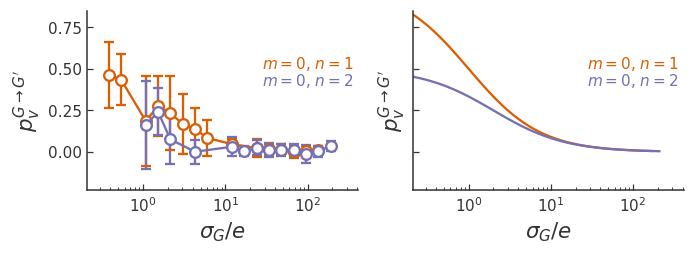

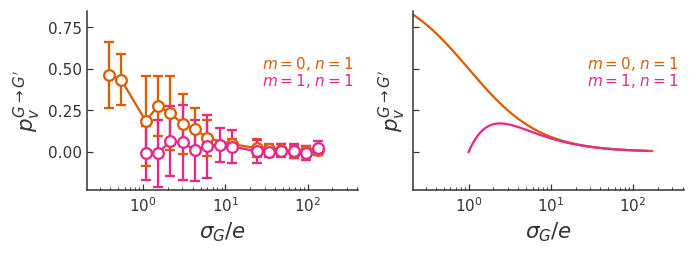

In [40]:
f, axa = plt.subplots(1, 2, sharex=False, sharey=True, figsize=(7, 3.5/golden))
ax = plt.gca()
plot_aux(axa[0], 0, 1, True, azp.colors[1], what='data', fmt="o-")
plot_aux(axa[1], 0, 1, True, azp.colors[1], what='th', fmt="o-")
plot_aux(axa[0], 0, 2, True, azp.colors[2], what='data', fmt="o-")
plot_aux(axa[1], 0, 2, True, azp.colors[2], what='th', fmt="o-")
for i in range(2):
    axa[i].text(2, 0.5, r"$m=%s$"%0 + ", " + r"$n=%s$"%1, color=azp.colors[1], ha='center')
    axa[i].text(2, 0.4, r"$m=%s$"%0 + ", " + r"$n=%s$"%2, color=azp.colors[2], ha='center')
    axa[i].set_ylim(-0.23, 0.85)
f.savefig(os.getcwd() + "/extended_data_figures/edf_9a1.svg"%fig_order, fmt='svg')

f, axa = plt.subplots(1, 2, sharex=False, sharey=True, figsize=(7, 3.5/golden))
ax = plt.gca()
plot_aux(axa[0], 0, 1, True, azp.colors[1], what='data', fmt="o-")
plot_aux(axa[1], 0, 1, True, azp.colors[1], what='th', fmt="o-")
plot_aux(axa[0], 1, 1, True, azp.colors[3], what='data', fmt="o-")
plot_aux(axa[1], 1, 1, True, azp.colors[3], what='th', fmt="o-")
for i in range(2):
    axa[i].text(2, 0.5, r"$m=%s$"%0 + ", " + r"$n=%s$"%1, color=azp.colors[1], ha='center')
    axa[i].text(2, 0.4, r"$m=%s$"%1 + ", " + r"$n=%s$"%1, color=azp.colors[3], ha='center')
    axa[i].set_ylim(-0.23, 0.85)
f.savefig(os.getcwd() + "/extended_data_figures/edf_9a2.svg"%fig_order, fmt='svg')

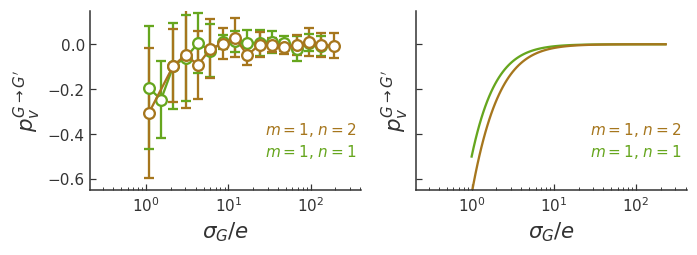

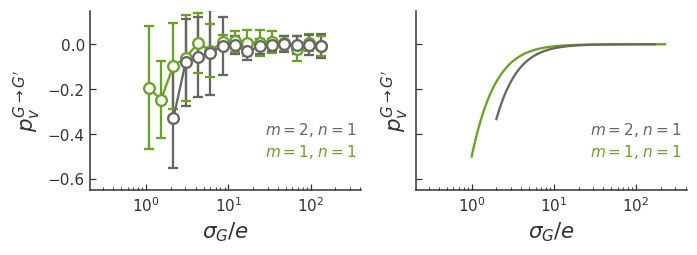

In [41]:
f, axa = plt.subplots(1, 2, sharex=False, sharey=True, figsize=(7, 3.5/golden))
ax = plt.gca()
m = [1, 1]
n = [1, 2]
plot_aux(axa[0], m[0], n[0], False, azp.colors[4], what='data', fmt="o-")
plot_aux(axa[1], m[0], n[0], False, azp.colors[4], what='th', fmt="o-")
plot_aux(axa[0], m[1], n[1], False, azp.colors[6], what='data', fmt="o-")
plot_aux(axa[1], m[1], n[1], False, azp.colors[6], what='th', fmt="o-")
for i in range(2):
    axa[i].text(2, -0.5, r"$m=%s$"%m[0] + ", " + r"$n=%s$"%n[0], color=azp.colors[4], ha='center')
    axa[i].text(2, -0.40, r"$m=%s$"%m[1] + ", " + r"$n=%s$"%n[1], color=azp.colors[6], ha='center')
    axa[i].set_ylim(-0.65, 0.15)
f.savefig(os.getcwd() + "/extended_data_figures/edf_9b1.svg"%fig_order, fmt='svg')

f, axa = plt.subplots(1, 2, sharex=False, sharey=True, figsize=(7, 3.5/golden))
ax = plt.gca()
m = [1, 2]
n = [1, 1]
plot_aux(axa[0], m[0], n[0], False, azp.colors[4], what='data', fmt="o-")
plot_aux(axa[1], m[0], n[0], False, azp.colors[4], what='th', fmt="o-")
plot_aux(axa[0], m[1], n[1], False, azp.colors[7], what='data', fmt="o-")
plot_aux(axa[1], m[1], n[1], False, azp.colors[7], what='th', fmt="o-")
for i in range(2):
    axa[i].text(2, -0.5, r"$m=%s$"%m[0] + ", " + r"$n=%s$"%n[0], color=azp.colors[4], ha='center')
    axa[i].text(2, -0.40, r"$m=%s$"%m[1] + ", " + r"$n=%s$"%n[1], color=azp.colors[7], ha='center')
    axa[i].set_ylim(-0.65, 0.15)
f.savefig(os.getcwd() + "/extended_data_figures/edf_9b2.svg"%fig_order, fmt='svg')

### Other values for m & n parameters

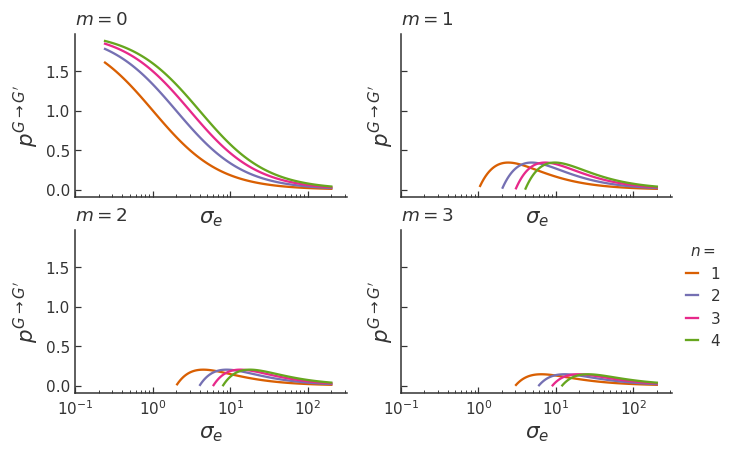

In [475]:
def plot_aux_data(ax, m, n, color, xmax=200, fmt="o", ms=7, mew=1.5, lw=1.5, cs=3, log=1):
    temp_ = temp[(np.isclose(temp.m, m)) & (np.isclose(temp.n, n))]
    #ax.plot(np.log10(temp_.sigma_e), temp_.abs_p_v, '.', color=color, alpha=0.3)
    nbins = 20
    xbins = np.logspace(np.log10(0.08/0.42), np.log10(xmax), nbins+1)
    ix = np.digitize(temp_.sigma_e, xbins) - 1
    y_ = np.array([temp_.abs_p_v[ix == i].mean() for i in range(nbins)])
    z_ = np.array([temp_.abs_p_v[ix == i].std() for i in range(nbins)])
    w_ = np.array([len(temp_.abs_p_v[ix == i]) for i in range(nbins)])
    x_ = np.array([np.log10((xbins[i] + xbins[i+1])*0.5) for i in range(nbins)])
    M = np.invert(np.isnan(y_)) * (w_ >= 3)
    if log:
        ax.errorbar(x_[M], np.log10(y_[M]), yerr=np.log10(z_[M]), fmt=fmt, color=color, ms=ms, markerfacecolor="w", markeredgewidth=mew, capsize=cs, linewidth=lw)
    else:
        ax.errorbar(x_[M], y_[M], yerr=z_[M], fmt=fmt, color=color, ms=ms, markerfacecolor="w", markeredgewidth=mew, capsize=cs, linewidth=lw)        
    
def plot_aux_th(ax, m, n, color, xmax=200, lw=1.5, label="", log=1):
    xmin = max(n*m, 0.08/0.42)+0.05
    x = np.logspace(np.log10(xmin), np.log10(xmax), 100)
    y = 2*n*(1-(m*n)/x)/(x+n)
    if log:
        ax.plot(np.log10(x), np.log10(y), color=color, lw=lw, label=label)
    else:
        ax.plot(np.log10(x), y, color=color, lw=lw, label=label)
    
def tick_aux(ax):
    mjt, mjtlab, mnt = azp.custom_log_ticks(-1, 3, base_10=True)
    ax.set_xticks(mjt, minor=False)
    ax.set_xticks(mnt, minor=True)
    ax.set_xticklabels(mjtlab)
    ax.set_xlim(-1, 2.5)
    ax.set_ylabel(r"$p^{G \rightarrow G'}$", fontsize=14)
    ax.set_xlabel(r"$\sigma_e$", fontsize=14)

x, y = [2, 2], [1, 1.2]
f, axa = plt.subplots(2, 2, figsize=(7, 3.5/golden*2), sharex=True, sharey=True)
for m in range(4):
    ax = axa[m/2, m%2]
    ax.set_title(r"$m=%s$"%m, loc="left")
    for n in range(1, 5):
        plot_aux_th(ax, m, n, azp.colors[n], log=log, label=str(n))
    tick_aux(ax)
axa[1, 1].legend(bbox_to_anchor=(1, 1), title=r"$n=$", handlelength=0.8)
f.savefig(os.getcwd() + "/extended_data_figures/edf_8.svg"%fig_order, fmt='svg')

# Order for doublets

In [60]:
def compare_triplets_order(name_rates):
    size = 5
    #temp = data_[data_.nb_az == size]
    temp = data_[:]

    res = []
    epsilon = 0.00
    random_rates = np.random.rand(16)
    #random_rates = np.arange(16)
    N = 1
    for name, row in temp.iterrows():
        if name_rates == "data":
            y = row["az_gd"]
        elif name_rates == "kb":
            y = [azm.degree(g, row["az_list"], 1, 'in', rates) for g in azm.transform(row["az_list"])]
        elif name_rates == "random":
            y = az.norm_array([random_rates[G.index(g)] for g in azm.transform(row["az_list"])])
        elif name_rates == "ka":
            y = azm.asymptotic_solution(row["az_list"], ka_rates)[0]
        n = len(y)
        x = azm.transform(row["az_list"])
        d = {x[i]:y[i] for i in range(n)}
        for c in list(combinations(x, 2)):
            o = np.array([d[c[i]] for i in range(2)])
            if o[0] == o[1]:
                res.append([azm.transform(list(c)), "="])
            if o[0] != o[1]:
                res.append([azm.transform(list(c)), "<".join(np.array(c)[o.argsort()])])
    res = pd.DataFrame(res, columns=["doublets", "order"])

    Y = []
    for name, group in res.groupby("doublets").filter(lambda x: len(x) >= 0).groupby("doublets"):
        y = group.groupby("order").size().values
        y = y.max()/float(y.sum())
        Y.append(y)
    print(len(Y))
    f = plt.figure()
    ax = plt.gca()
    ax.hist(Y, np.linspace(0, 1, 20), color=azp.colors[1])
    ax.set_xlabel("Proportion of top triplet order")
    ax.set_ylabel("Triplet count")
    
    return res, np.array(Y)

120
               doublets  order
18614  0000000001000010  GU<UC
35355  0000000001001000  GA<UC
38824  0001100000000000  CA<AG
0.633333333333


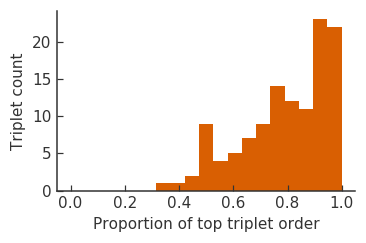

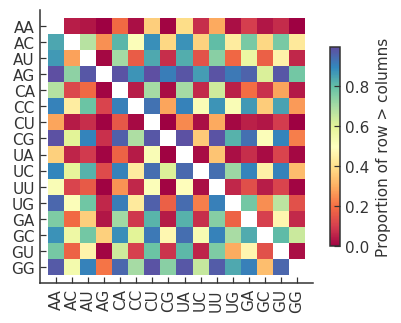

In [61]:
df, Y = compare_triplets_order("data")
print(df.sample(3))
print(float(sum(Y < 0.9))/len(Y))

M = np.zeros((16, 16))
for i in range(16):
    for j in range(16):
        if i == j:
            M[i, j] = np.nan
        else:
            g = G[i]
            h = G[j]
            c = Counter(df[df.doublets == azm.transform([g, h])].order.values)
            v = float(c[h+"<"+g])/(c[g+"<"+h]+c[h+"<"+g]+c["="])
            M[i, j] = v
f = plt.figure(figsize=(4, 4))
ax = plt.gca()
cmap = mpl.cm.get_cmap("Spectral")
cmap.set_bad('w')
im = ax.imshow(M, cmap=cmap)
ax.set_xticks(range(16))
ax.set_xlim(-1, 16)
ax.set_ylim(16, -1)
ax.set_yticks(range(16))
ax.set_xticklabels(G, rotation=90)
ax.set_yticklabels(G, rotation=0)
cbar = f.colorbar(im, shrink=0.6, ticks=[0., 0.2, 0.4, 0.6, 0.8, 1.])
cbar.set_label("Proportion of row > columns")
f.savefig(os.getcwd() + "/extended_data_figures/edf_6a.svg"%fig_order, fmt='svg')